# Introduction

Megaline, a phone company, seeks to find its most profitable phone plan between. They wish to do so they can allocate its advertising budget accordingly. A preliminary analysis that takes a small client selection will be taken to draw inferences from. This data includes who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. 

## Process

To determine which plan is better, statistical hypotheses about profitability will be undertaken.

To do this the following steps will take place:
1. Prepare Data
    - Initialize libraries
    - Load data
    - Convert datatypes
    - Handle duplicate, missing and odd values
    - Enrich data
    - Aggregate data 
    - Calculate revenue
2. Analyze Data
    - Call duration
    - Messages
    - Internet Usage
    - Total Revenue
3. Test Statistical Hypotheses

## Phone Plans

When finding

Currently two plans exist, charging different rates:

**Surf**

1. Monthly charge: $20
2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    - 1 minute: 3 cents
    - 1 text message: 3 cents
    - 1 GB of data: $10

**Ultimate**

1. Monthly charge: $70
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
    - 1 minute: 1 cent
    - 1 text message: 1 cent
    - 1 GB of data: $7


## Data Description

5 datasets containing 500 users data has been provided. These include:

The `users` table (data on users):

- _user_id_ — unique user identifier
- _first_name_ — user's name
- _last_name_ — user's last name
- _age_ — user's age (years)
- _reg_date_ — subscription date (dd, mm, yy)
- _churn_date_ — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- _city_ — user's city of residence
- _plan_ — calling plan name

The `calls` table (data on calls):

- _id_ — unique call identifier
- _call_date_ — call date
- _duration_ — call duration (in minutes)
- _user_id_ — the identifier of the user making the call

The `messages` table (data on texts):

- _id_ — unique text message identifier
- _message_date_ — text message date
- _user_id_ — the identifier of the user sending the text

The `internet` table (data on web sessions):

- _id_ — unique session identifier
- _mb_used_ — the volume of data spent during the session (in megabytes)
- _session_date_ — web session date
- _user_id_ — user identifier

The `plans` table (data on the plans):

- _plan_name_ — calling plan name
- _usd_monthly_fee_ — monthly charge in US dollars
- _minutes_included_ — monthly minute allowance
- _messages_included_ — monthly text allowance
- _mb_per_month_included_ — data volume allowance (in megabytes)
- _usd_per_minute_ — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- _usd_per_message_ — price per text after exceeding the package limits
- _usd_per_gb_ — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)





The analysis on phone user data will first involve initializing, loading, and preparing the data. From here, the revenue of each user will be determined and aggregated on a monthly basis. This will allow for a comparison of calling, messaging, and internet usage behaviours between surf and ultimate plan users. Revenue will also be compared and used when looking to hypothesis testing. 

# Prepare Data

## Initialization

Load appropriate libraries.

In [1]:
# For loading and manipulating dataframe objects
import pandas as pd 
import numpy as np 

# For data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# For hypothesis testing
from scipy import stats

## Load data

Read users, calls, messages, internet, and plans CSV files. Save approriately.

In [2]:
# Load the data files into different DataFrames
users = pd.read_csv('data/megaline_users.csv')
calls = pd.read_csv('data/megaline_calls.csv')
messages = pd.read_csv('data/megaline_messages.csv')
internet = pd.read_csv('data/megaline_internet.csv')
plans = pd.read_csv('data/megaline_plans.csv')

## Clean Data

Datatypes will be converted where necessary. Each dataset will be checked for duplicate, missing and odd values. Data will also be enriched.

These will be evaluated, fixed and enriched where appropriate.

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Print a sample of data for plans
plans.sample(2)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


No missing data exists and all data is in the correct data type. We can reorder the data so that the plan name is given first.

### Fix data

Reorder columns

In [5]:
# Reorder columns
# Save list of columns
cols = plans.columns.tolist()

# Reorder last value as first followed by others
cols = cols[-1:] + cols[:-1]

# Save plans with reorders cols
plans = plans[cols]

# Show plans
plans

,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,surf,50,15360,500,20,10,0.03,0.03
1,ultimate,1000,30720,3000,70,7,0.01,0.01


### Enrich data

Add a column for megabytes to gigabytes conversion. This will be helpful later when determing how many gigabytess have been used. 1024 megabytes equate to one gigabyte.

In [6]:
# Set gb_per_month as mb_per_month divided by 1024 
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024

# Drop mb_per_month_included column
plans = plans.drop(columns='mb_per_month_included')

## Users

In [7]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Print a sample of data for users
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
120,1120,Abraham,Mcconnell,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-03,surf,NaN
268,1268,Britni,Bowers,33,"Fresno, CA MSA",2018-01-13,surf,NaN
241,1241,Lala,Walls,24,"Richmond, VA MSA",2018-08-27,surf,NaN
318,1318,Huey,Walsh,54,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-09-29,surf,NaN
13,1013,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN


In [9]:
# ID column should only contain unique values. Check for duplicates by counting values for id
users['user_id'].value_counts(ascending=False)

user_id
1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: count, Length: 500, dtype: int64

The registration and churn date is in the form of an object. This needs to be changed to date-time using pandas. The city also includes 'MSA' at the end of each string. This will be removed using the replace method. The User ID column only contains unique values so no duplicates exist.

### Fix Data

Change registration and churn dates to date-time.

In [10]:
# reg_date to datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])

# churn_date to datetime
users['churn_date'] = pd.to_datetime(users['churn_date'])

Replace' MSA' within city columns.

In [11]:
#replace 'MSA' in city column with blank
users['city'] = users['city'].str.replace(' MSA','') 

## Calls

In [12]:
# Print the general/summary information about the calls' DataFrame
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Print a sample of data for calls
calls.sample(10)

,id,user_id,call_date,duration
118568,1412_852,1412,2018-08-24,5.89
48934,1176_33,1176,2018-10-28,5.02
118958,1415_6,1415,2018-09-13,0.00
111170,1390_619,1390,2018-07-11,10.43
46253,1167_336,1167,2018-10-26,10.29
81005,1291_605,1291,2018-08-12,9.63
64163,1232_460,1232,2018-04-12,6.98
9183,1042_109,1042,2018-03-05,5.61
67656,1243_44,1243,2018-11-01,13.21
137507,1498_444,1498,2018-12-17,11.00


In [14]:
# ID column should only contain unique values. Check for duplicates by counting values for id
calls['id'].value_counts(ascending=False).head()

id
1000_93      1
1329_1214    1
1329_1253    1
1329_1252    1
1329_1245    1
Name: count, dtype: int64

Call date will be converted to date-time. Since call minutes are rounded up to the nearest number, duration type will be converted to an integer. Values round down when using this method, so each are increased by one to reflect plan terms where each minute is rounded up.  All User IDs are unique. 

### Fix data

Convert call date to date-time.

In [15]:
# Convert call date to datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])

Round up duration to the nearest minute, save column as an integer

In [16]:
# Round duration up using np.ceil()
calls['duration'] = np.ceil(calls['duration'])

# Save as type int
calls['duration'] = calls['duration'].astype('int')

### Enrich data

Create a column to group data by month.

In [17]:
# Assign new column 'month'
calls['month'] = calls['call_date'].dt.month

## Messages

In [18]:
# Print the general/summary information about the messages' DataFrame
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Print a sample of data for messages
messages.sample(5)

,id,user_id,message_date
4580,1043_969,1043,2018-06-28
24661,1146_216,1146,2018-12-05
33119,1206_161,1206,2018-08-26
44747,1301_10,1301,2018-12-18
17403,1114_299,1114,2018-12-27


In [20]:
# ID column should only contain unique values. Check for duplicates by counting values for id, descending order
messages['id'].value_counts(ascending=False).head()

id
1000_125    1
1330_126    1
1330_119    1
1330_117    1
1330_114    1
Name: count, dtype: int64

Message date will be converted to date-time. Other wise, dtypes are appropriate, no missing data is shown, and all ID values are unique.

### Fix data

Convert message date to date-time.

In [21]:
# Convert message date to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

### Enrich data

As with calls data, assign new column 'month'.

In [22]:
# Assign new column 'month'
messages['month'] = messages['message_date'].dt.month

## Internet

In [23]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [24]:
# Print a sample of data for the internet traffic
internet.sample(5)

,id,user_id,session_date,mb_used
18810,1084_72,1084,2018-11-25,347.86
104176,1498_239,1498,2018-04-14,517.42
7529,1041_369,1041,2018-04-07,251.49
54799,1248_15,1248,2018-12-06,156.60
76200,1358_386,1358,2018-08-18,214.43


In [25]:
# ID column should only contain unique values. Check for duplicates by counting values for id, descending order
internet['id'].value_counts(ascending=False).head()

id
1000_13    1
1327_20    1
1327_30    1
1327_29    1
1327_28    1
Name: count, dtype: int64

Message date will be converted to date-time. As charges occur in gigabytes, data used will be converted to gigabytes. Otherwise, data types are appropriate, no missing data is shown, and all ID values are unique.

### Fix data

Convert session date to date time.

In [26]:
# Convert session date to datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

### Enrich data

As with above sets, create new column for month.

In [27]:
# Assign new column 'month'
internet['month'] = internet['session_date'].dt.month

Create new column for gigabytes used. Drop megabytes column after conversion.

In [28]:
# Create new column for gb used
internet['gb_used'] = internet['mb_used'] / 1024

# Drop mb_used column
internet = internet.drop(columns = 'mb_used')

## Study plan conditions

Print study plan condtions to make sure they are understood.

In [29]:
# Print out the plan conditions
plans

,plan_name,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,surf,50,500,20,10,0.03,0.03,15.0
1,ultimate,1000,3000,70,7,0.01,0.01,30.0


## Aggregate data per user

Aggregating the data will make it easier to analyze how a user behaves in a one month period. 

For calls, messages and internet dataframes, group data by user ID and month. Save appropriate metrics that will be necessary to determine revenue as outlined by the plan above.

Once data is grouped, the data is aggregated with merges. This is done with outer merges to ensure that users who may not call, text or use data are all accounted for. Note however that this assumes that all users do one of those activities.

### Group Data

In [30]:
# Calculate the number of calls made by each user per month. Save the result.
calls_num = calls.groupby(['user_id','month'])['id'].count().reset_index().rename(columns={'id': 'calls'})

In [31]:
# Calculate the amount of minutes spent by each user per month. Save the result.
calls_mins = calls.groupby(['user_id','month'])['duration'].sum().reset_index().rename(columns={'duration': 'call_minutes'})

In [32]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_num = messages.groupby(['user_id','month'])['id'].count().reset_index().rename(columns={'id': 'messages'})

In [33]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_vol = internet.groupby(['user_id','month'])['gb_used'].sum().reset_index()

# Round up Gigabyte values
internet_vol['gb_used'] = np.ceil(internet_vol['gb_used'])

### Merge Data

In [34]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
df = calls_num.merge(calls_mins, on=['user_id','month'], how='outer') \
            .merge(messages_num, on=['user_id','month'], how='outer') \
            .merge(internet_vol, on=['user_id','month'], how='outer')

In [35]:
# Add the plan information
# Merge plan type from users df
df = df.merge(users[['user_id','plan']], on='user_id')

In [36]:
# Merge plan information from plan on 'plan'
df = df.merge(plans, left_on='plan', right_on='plan_name')

#drop duplicated 'plan_name' column
df = df.drop(columns = 'plan_name')

In [37]:
# Replace NaN values with 0
df = df.fillna(0)

### Calculate Revenue

This is done by adding the initial monthly payment with excess call duration, messaging and internet usage costs. A function that calculates the excess will be created that calculates charges when a user goes over the limit they have on a plan. This will then be utilized in a loop to calculate total revenue.

In [38]:
# Create function 'excess' that returns excess charges if the used service exceeds the service allotted
def excess(used, allotted, excess_rate):

    if used > allotted:
        return ((used - allotted) * excess_rate)
    else:
        return 0

In [39]:
# Create revenue list equal to 0, matched to length of df
revenue = [None] * len(df)

# Create loop length of df
for i in range(len(df)):
    # Add base monthly payment to 'revenue'
    revenue[i] = df['usd_monthly_pay'][i]
    
    # Add excess call duration costs
    revenue[i] += excess(df['call_minutes'][i], df['minutes_included'][i], df['usd_per_minute'][i])
    
    # Add excess message costs
    revenue[i] += excess(df['messages'][i], df['messages_included'][i], df['usd_per_message'][i])
    
    # Add excess data costs, convert gb_used to integer (rounds down) and add 1 (round up)
    revenue[i] += excess((df['gb_used'][i]), df['gb_per_month_included'][i], df['usd_per_gb'][i])

# Create revenue column equal to revenue values
df['revenue'] = revenue

# Analysis


## Study user behaviour

Whether the surf or ultimate plan results in greater revenue depends on excess charges. As the surf plan is 50 dollars cheaper, these excess charges must be result in 50 dollars per user. Thus, studying user behaviour and more specifically user calling, messaging and internet surfing is essential.

To highlight how surf and ultimate plan users behave, data will be plotted for each month from January to December. Histograms and boxplots will also be used to see how behaviour is distributed between users. Data is split into surf and ultimate users to determine mean averages, variances and standard devaiations. This will explain what users of each plan are doing and answer which plan is better.

In [40]:
# Save monthly user data for surf and ultimate plans
surf = df[df['plan'] == 'surf']
ultimate = df[df['plan'] == 'ultimate']

### Calls

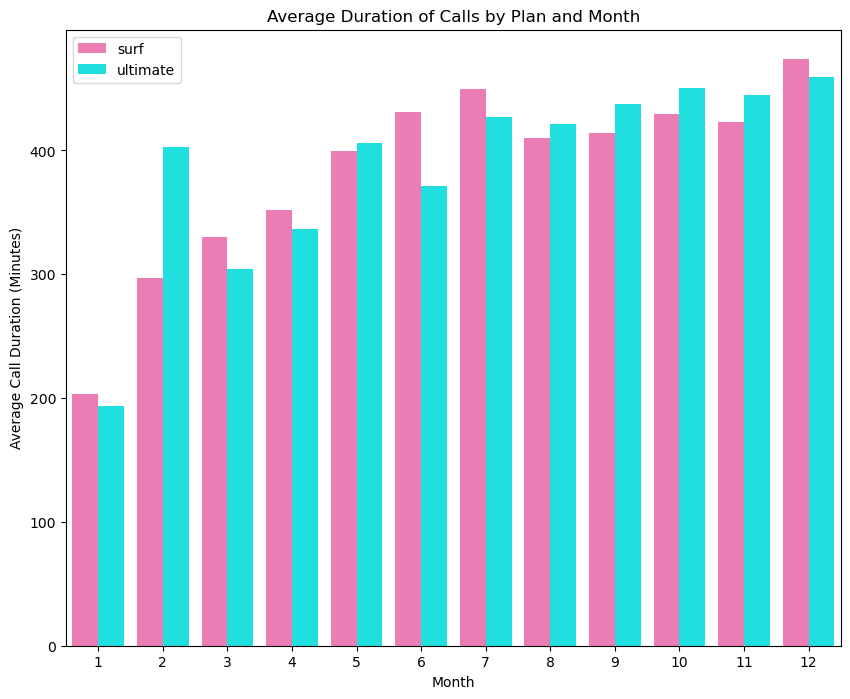

In [41]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.

# Create groupby to find average duration  by each plan type and month
call_average = df.groupby(['plan','month'])['call_minutes'].mean().reset_index()

# Increase plot size
plt.figure(figsize=(10,8))

# Create barplot from seaborn, 
sns.barplot(data = call_average, x = 'month', y='call_minutes', hue = 'plan', 
            palette = ['hotpink','aqua'], errorbar=None) \
            .set(xlabel='Month', ylabel='Average Call Duration (Minutes)', \
                 title='Average Duration of Calls by Plan and Month')

plt.legend(loc='upper left')

plt.show()

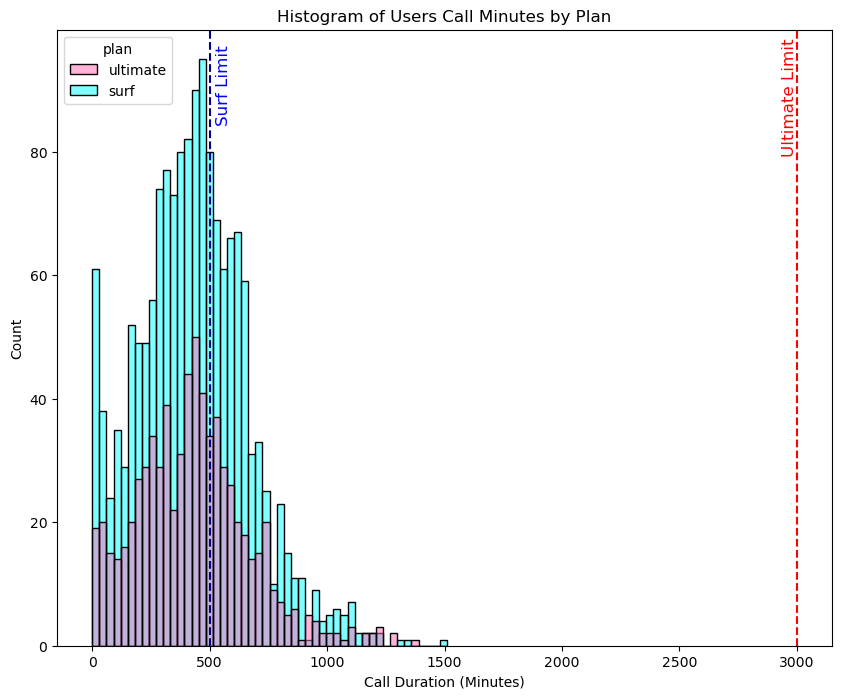

In [69]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

# Increase plot size
plt.figure(figsize=(10,8))

# Create histogram from seaborn
sns.histplot(data = df, x = 'call_minutes', hue = 'plan', \
            palette = ['hotpink','aqua'], bins = 50) \
            .set(xlabel='Call Duration (Minutes)', ylabel='Count', \
                 title='Histogram of Users Call Minutes by Plan')
            
# Add vertical lines at surf and ultimate limits
plt.axvline(x=500, color='darkblue', linestyle='--', label='Surf Limit')
plt.axvline(x=3000, color='red', linestyle='--', label='Ultimate Limit')

# Add text labels for surf and ultimate limits rotated 90 degrees
plt.text(525, plt.gca().get_ylim()[1]*0.85, 'Surf Limit', color='blue', fontsize=12, ha='left', rotation=90)
plt.text(3000, plt.gca().get_ylim()[1]*0.8, 'Ultimate Limit', color='red', fontsize=12, ha='right', rotation=90)
            
# save plot as png in pics folder
plt.savefig('pics/call_minutes_hist.png')

# show plot
plt.show()

In [43]:
# Print surf duration mean
print('surf duration mean = ', round(surf['call_minutes'].mean(), 2))

# Print ultimate duration mean
print('ultimate duration mean = ', round(ultimate['call_minutes'].mean(), 2), '\n')

# Print surf duration variance
print('surf duration variance = ', round(surf['call_minutes'].var(), 2))

# Print ultimate duration variance
print('ultimate duration variance = ', round(ultimate['call_minutes'].var(), 2), '\n')

# Print surf duration standard deviation
print('surf duration standard deviation = ', round(surf['call_minutes'].std(), 2))

# Print ultimate duration standard deviation
print('ultimate duration standard deviation = ', round(ultimate['call_minutes'].std(), 2))


surf duration mean =  428.75
ultimate duration mean =  430.45 

surf duration variance =  54968.28
ultimate duration variance =  57844.46 

surf duration standard deviation =  234.45
ultimate duration standard deviation =  240.51


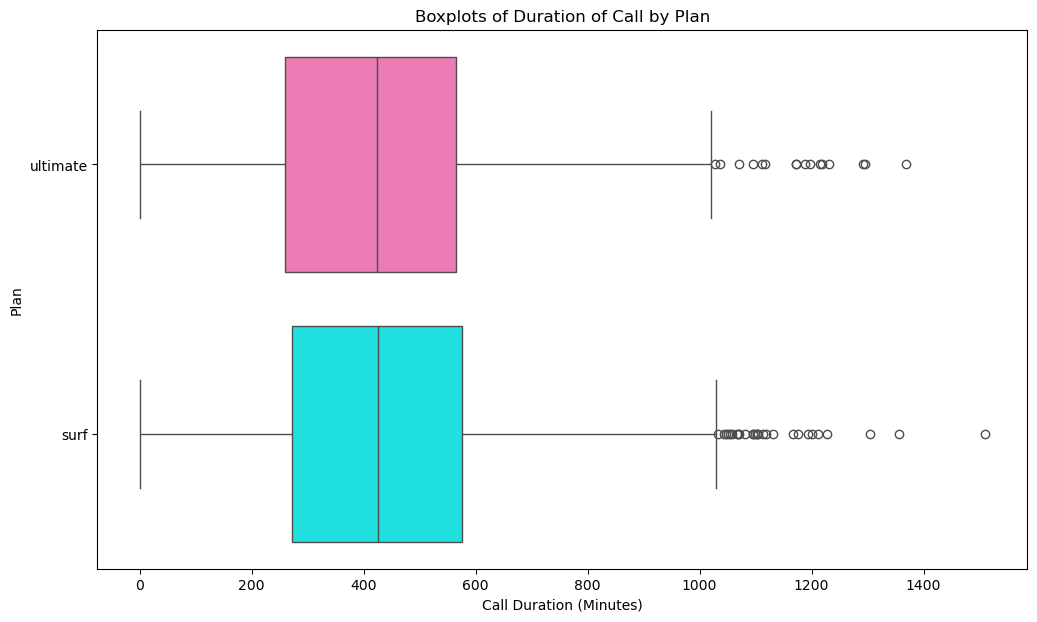

In [44]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Increase plot size
plt.figure(figsize=(12,7))

# Create boxplots of duration by 
sns.boxplot(data = df, x='call_minutes', y='plan',hue='plan', palette = ['hotpink','aqua'])\
                    .set(xlabel='Call Duration (Minutes)', ylabel='Plan', \
                     title='Boxplots of Duration of Call by Plan')

plt.show()

 **Analysis**: Despite having different call duration limits, ultimate and surf plan users show little difference in the time they spend talking on the phone. Whilst ultimate plan members were spending 100 minutes more on average in Febraury, surf users quickly caught up. By December, the average for both plan users is comparable at around 470 minutes. 
 
What's interesting is that ultimate users have an extra 2500 minutes accessible under their plan, but not many are exceeding 500, which is the other plans limit. This is shown in the histogram where both plan users peak at around 500 users. However, both are right skewed, showing that many surf users still go over their 500 minute limit. 

Duration means for both are almost exactly the same, yet are more likely to be balanced by the large number of users who call very rarely and outliers who use upto 1400 minutes per month. Interestingly, no ultimate users get anywhere near their 3000 minute cap. Ultimate users do show a slightly higher variance among duration, and so results among ultimate users are more varied than surf users.

**Conclusion:** The surf user plan should create more revenue as over 25% go over their limits. This compares to 0% of ultimate users. However, this is not enough by itself to overcome the initial price difference of 50 dollars. All else aside, the surf user with 1500 minutes is paying 30 dollars more. Further analysis is needed to see if messages and internet usage could tip this value up more.

### Messages

/var/folders/mc/2h3nzhln2bs9klxfl4_8hd8w0000gn/T/ipykernel_85199/2295081231.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = message_average, x = 'month', y='messages', hue = 'plan',


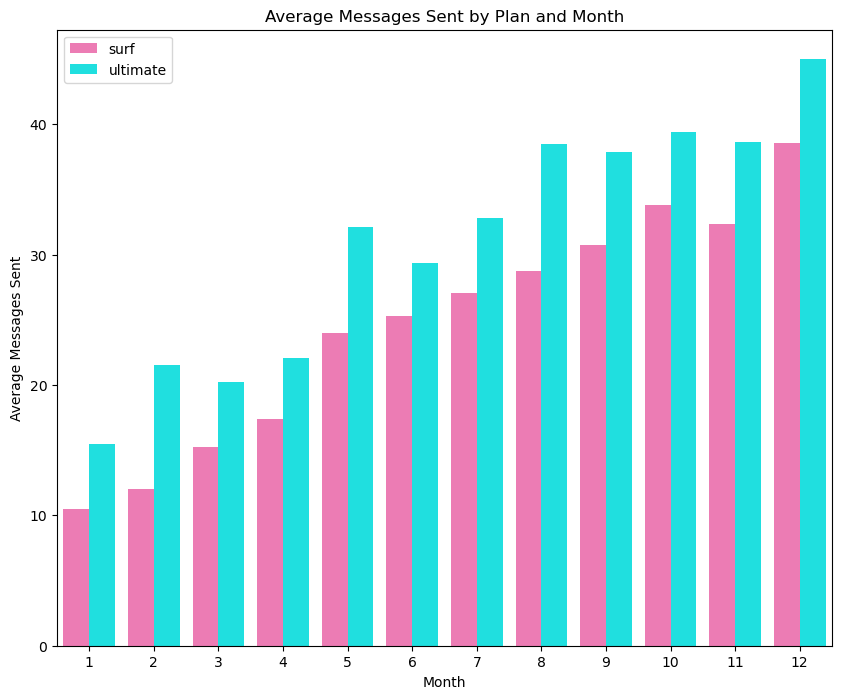

In [45]:
# Compare average messages per each plan per each distinct month. Plot a bar plot to visualize it.

# Create groupby to find average duration  by each plan type and month
message_average = df.groupby(['plan','month'])['messages'].mean().reset_index()

# Increase plot size
plt.figure(figsize=(10,8))

# Create barplot from seaborn, 
sns.barplot(data = message_average, x = 'month', y='messages', hue = 'plan', 
            palette = ['hotpink','aqua'], ci = None) \
            .set(xlabel='Month', ylabel='Average Messages Sent', \
                 title='Average Messages Sent by Plan and Month')

plt.legend(loc='upper left')

plt.show()

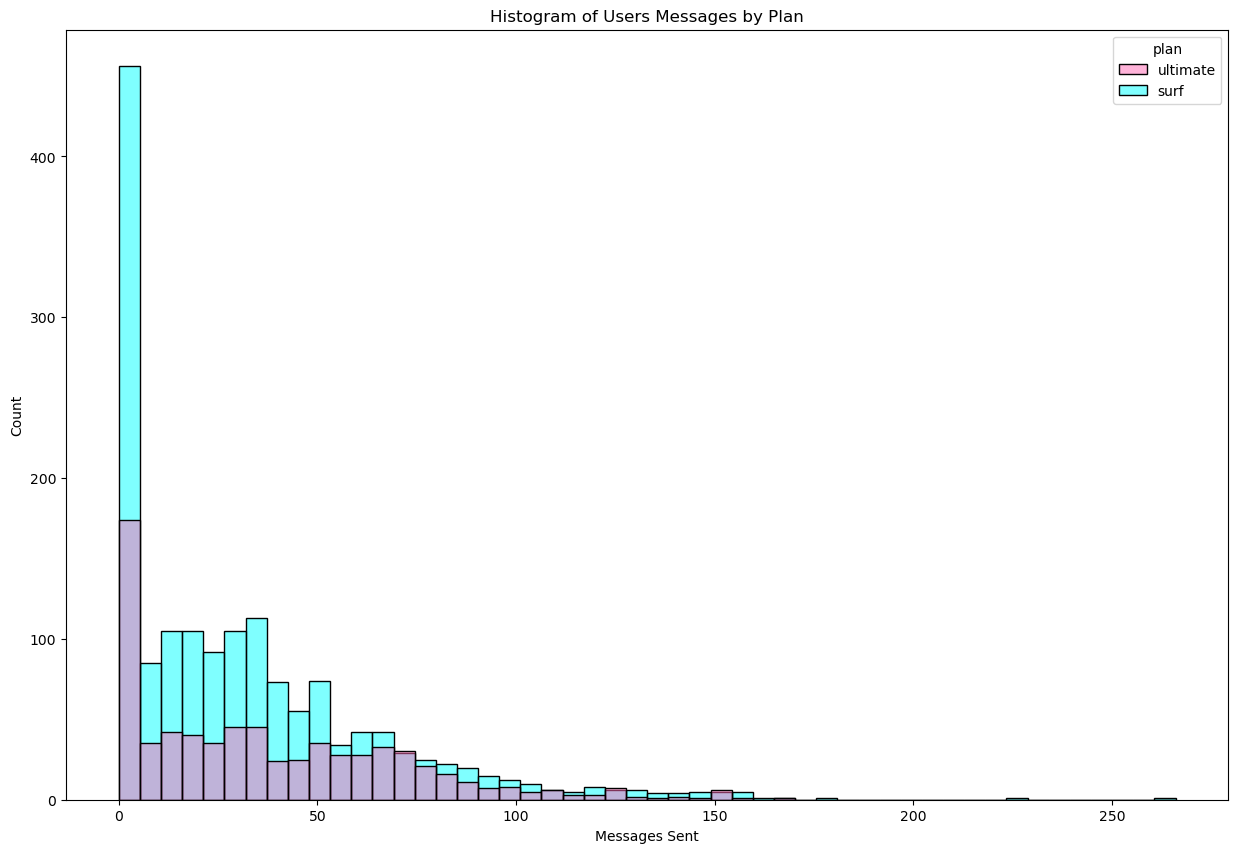

In [46]:
# Compare the number of messages users of each plan require each month. Plot a histogram.

# Increase plot size
plt.figure(figsize=(15,10))

# Create histogram from seaborn
sns.histplot(data = df, x = 'messages', hue = 'plan', \
            palette = ['hotpink','aqua'], bins = 50) \
            .set(xlabel='Messages Sent', ylabel='Count', \
                 title='Histogram of Users Messages by Plan')

plt.show()

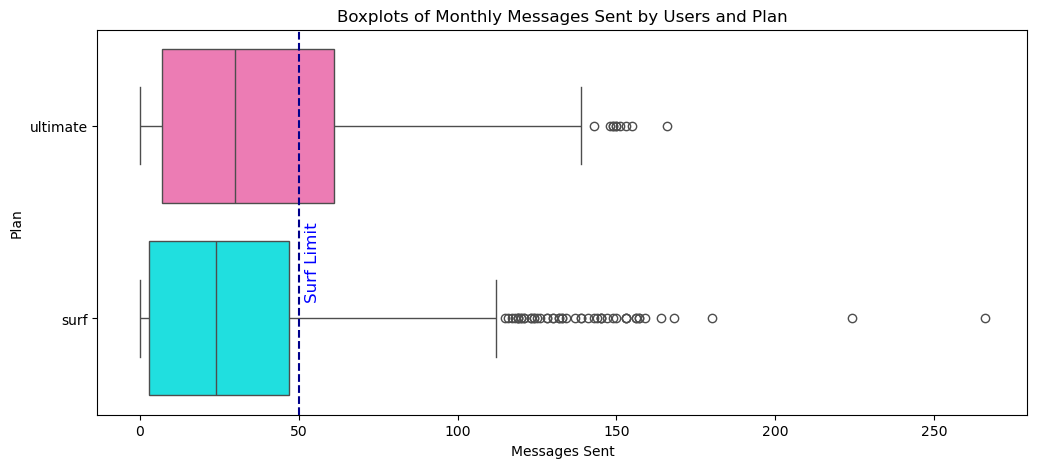

In [93]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Increase plot size
plt.figure(figsize=(12, 5))

# Create boxplots of duration by 
sns.boxplot(data = df, x='messages', y='plan', hue='plan', palette = ['hotpink','aqua'])\
                    .set(xlabel='Messages Sent', ylabel='Plan', \
                     title='Boxplots of Monthly Messages Sent by Users and Plan')
                    
# add limit lines
plt.axvline(x=50, color='darkblue', linestyle='--', label='Surf Limit')

# Add text labels for surf and ultimate limits rotated 90 degrees
plt.text(52, 0.9, 'Surf Limit', color='blue', fontsize=12, ha='left', rotation=90)


# save boxplot as png in pics folder
plt.savefig('pics/messages_boxplot.png')

plt.show()

In [48]:
# Calculate the mean, variance and standard deviation of monthly messages

# Print plan means
print('surf messages mean = ', round(surf['messages'].mean(),2))
print('ultimate messages mean = ', round(ultimate['messages'].mean(),2), '\n')

# Print duration variance
print('surf messages variance = ', round(surf['messages'].var(),2))
print('ultimate messages variance = ', round(ultimate['messages'].var(),2), '\n')

# Print duration standard deviation
print('surf messages variance = ', round(surf['messages'].std(),2))
print('ultimate messages variance = ', round(ultimate['messages'].std(),2), '\n')

surf messages mean =  31.16
ultimate messages mean =  37.55 

surf messages variance =  1126.72
ultimate messages variance =  1208.76 

surf messages variance =  33.57
ultimate messages variance =  34.77 



**Analysis**: A bigger difference in messages exists between users of differing plans than that of call duration. Ultimate plan users average about 5 more messages each month, albeit still under the surf plan cap. However, the trend seems to be increasing so it will be interesting to see if surf users will overcome this level in the coming months. 

This finding remains true as the histogram shows many users that don't send any messages. Ultimate users do proportionally tend to send more with a higher median value. The mean shows that ultimate users send over six messages more. However, the difference in standard deviation is slight and so results vary at around the same rate, albeit around a higher mean for ultimate users.

**Conclusion**: Ultimate plan users are not paying extra for text messages whilst texting more. 25% of Surf plan users are paying, however, at 3 cents per message. This total price is much smaller than what calling minutes are providing. For instance, even if all surf users were messaging as much as the highest monthly user, this would only be around 7 dollars.

### Internet

/var/folders/mc/2h3nzhln2bs9klxfl4_8hd8w0000gn/T/ipykernel_85199/3769022922.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = usage_average, x = 'month', y='gb_used', hue = 'plan',


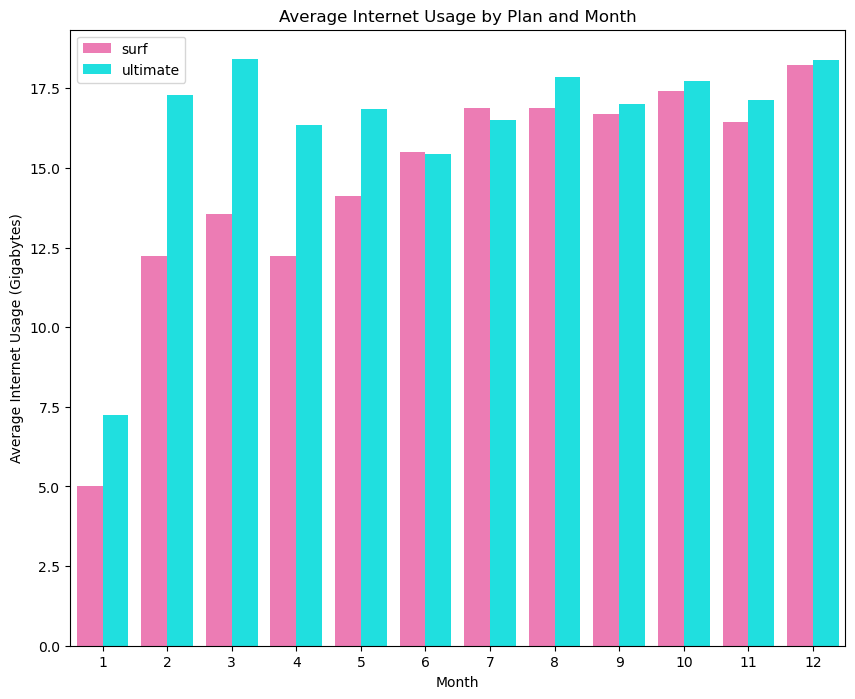

In [49]:
# Compare average internet usage per each plan per each distinct month. Plot a bar plot to visualize it.

# Create groupby to find average duration  by each plan type and month
usage_average = df.groupby(['plan','month'])['gb_used'].mean().reset_index()

# Increase plot size
plt.figure(figsize=(10,8))

# Create barplot from seaborn, 
sns.barplot(data = usage_average, x = 'month', y='gb_used', hue = 'plan', 
            palette = ['hotpink','aqua'], ci = None) \
            .set(xlabel='Month', ylabel='Average Internet Usage (Gigabytes)', \
                 title='Average Internet Usage by Plan and Month')

plt.legend(loc='upper left')

plt.show()

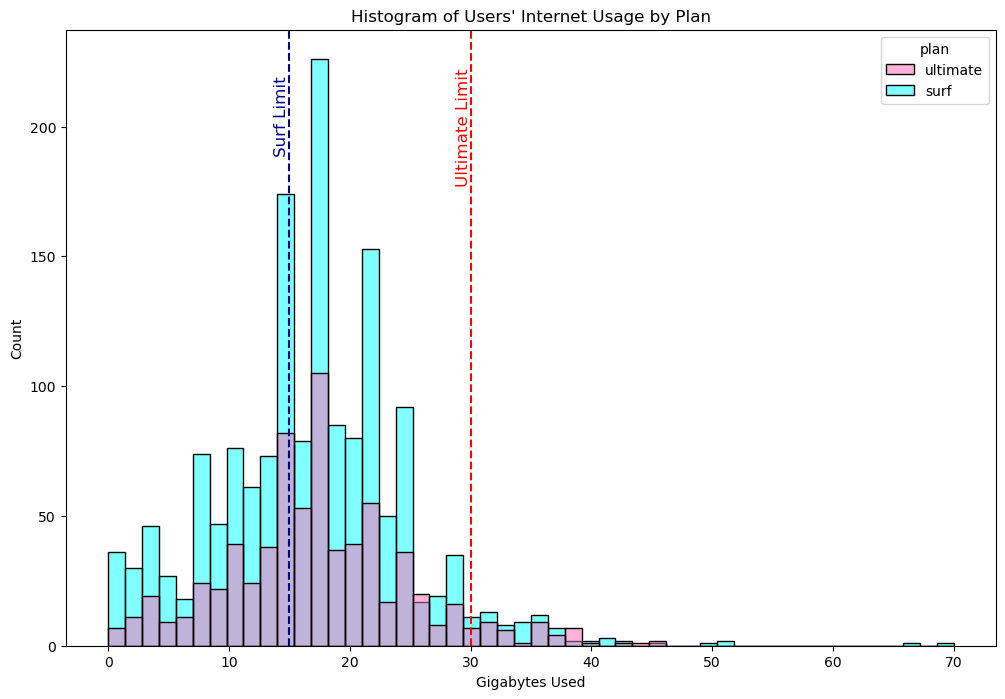

In [50]:
# Compare the users internet usage of each plan require each month. Plot a histogram.

# Increase plot size
plt.figure(figsize=(12,8))

# Create histogram from seaborn
sns.histplot(data=df, x='gb_used', hue='plan', palette=['hotpink', 'aqua'], bins=50)

# Set labels and title
plt.xlabel('Gigabytes Used')
plt.ylabel('Count')
plt.title("Histogram of Users' Internet Usage by Plan")

# Add vertical lines at surf and ultimate limits
plt.axvline(x=15, color='darkblue', linestyle='--')
plt.axvline(x=30, color='red', linestyle='--')

# Add text labels for surf and ultimate limits rotated 90 degrees
plt.text(15, plt.gca().get_ylim()[1]*0.8, 'Surf Limit', color='darkblue', fontsize=12, ha='right', rotation=90)
plt.text(30, plt.gca().get_ylim()[1]*0.75, 'Ultimate Limit', color='red', fontsize=12, ha='right', rotation=90)

# Save plot as png in pics folder
plt.savefig('pics/internet_usage_hist.png')

# Show plot
plt.show()


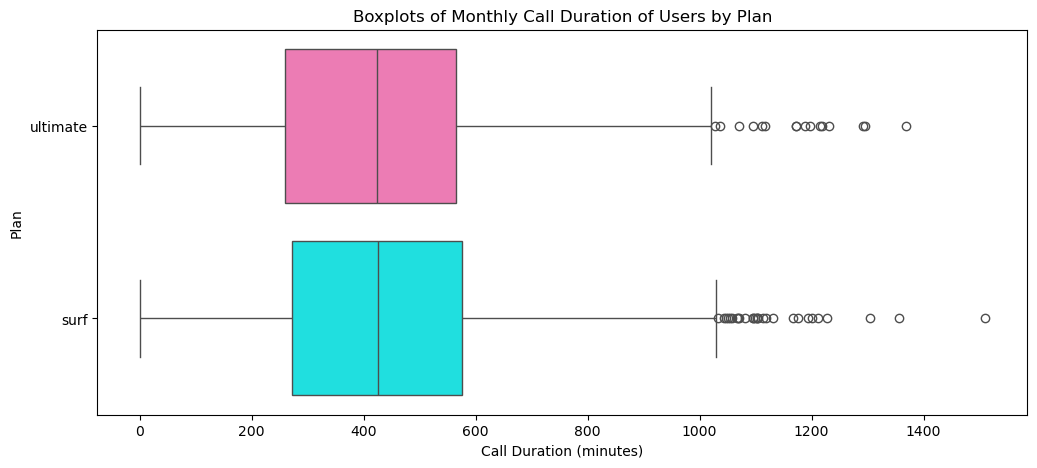

In [51]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Increase plot size
plt.figure(figsize=(12, 5))

# Create boxplot of call duration by plan
sns.boxplot(data=df, y='plan', x='call_minutes', hue='plan', palette=['hotpink', 'aqua']) \
                    .set(ylabel='Plan', xlabel='Call Duration (minutes)', \
                     title='Boxplots of Monthly Call Duration of Users by Plan')

# Show plot
plt.show()

In [52]:
# Calculate the mean, variance and standard deviation of monthly messages

# Print surf duration mean
print('surf internet usage mean = ', surf['gb_used'].mean().round(2))

# Print ultimate duration mean
print('ultimate internet usage mean = ', ultimate['gb_used'].mean().round(2))

print('')

# Print surf duration variance
print('surf internet usage variance = ', surf['gb_used'].var().round(2))

# Print ultimate duration variance
print('ultimate internet usage variance = ', ultimate['gb_used'].var().round(2))

print('')

# Print surf duration variance
print('surf internet usage standard deviation = ', surf['gb_used'].std().round(2))

# Print ultimate duration variance
print('ultimate internet usage standard deviation = ', ultimate['gb_used'].std().round(2))

surf internet usage mean =  16.67
ultimate internet usage mean =  17.31



AttributeError: 'float' object has no attribute 'round'

**Analysis**: Internet usage at the start of the year did vary, but has evened out towards the end of the year. In February and March, ultimate users consumed on average 5 gigabytes more than surf users. However, from June onwards, the difference has been trivial. By the end of the year, users on both plans are averaging almost 17.5 gigabytes per month. For surf users this is higher than their allotted 15 gigabytes, but still significantly under ultimates allotted 30 gigabytes. 

There do seem to be proportionally more surf users who use very little data, but apart from that, distributions between the two plans follow a similar pattern. Where some surf users have used more than 50 gigabytes, none exist among ultimate plan users. The mean average is higher in ultimate users by over 0.6 gigabytes, but variance is higher among surf users.

**Conclusion**: Whilst some ultimate users are paying for excess internet, almost half of surf users are. As the cost for an extra gigabyte is 7 dollars, this becomes a significant revenue source. 25 percent of surf users are paying atleast 50 dollars extra for internet alone. This in combination with call duration and message costs may be enough to make the surf plan more profitable so long as users continue to behave similarly. An analysis on total revenue itself will shed more light.

## Revenue

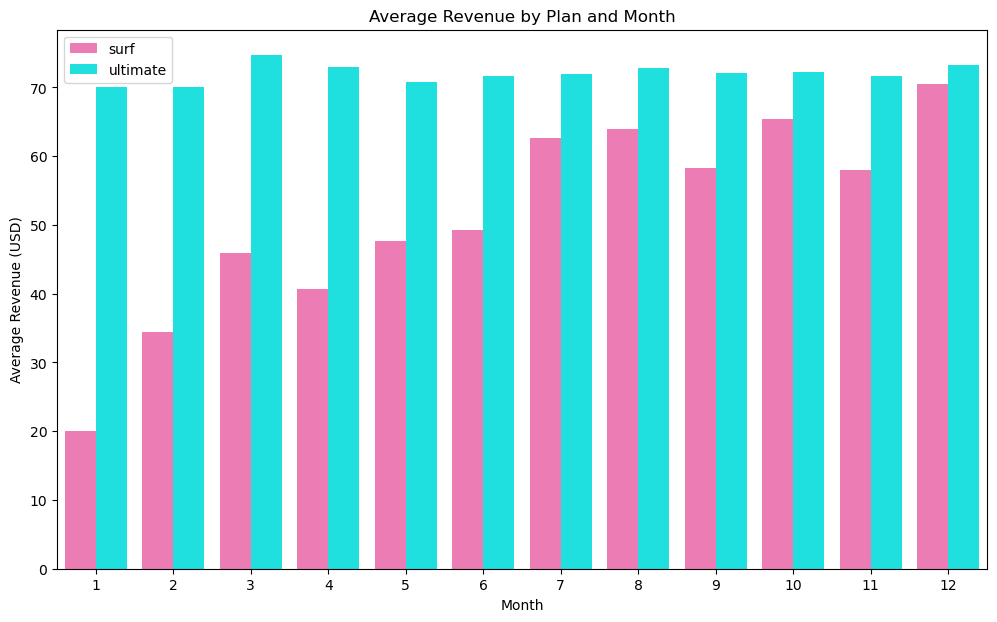

In [ ]:
# Compare average revenue per each plan per each distinct month. Plot a bar plot to visualize it.

# Create groupby to find average duration  by each plan type and month
usage_average = df.groupby(['plan','month'])['revenue'].mean().reset_index()

# Increase plot size
plt.figure(figsize=(12,7))

# Create barplot from seaborn, 
sns.barplot(data = usage_average, x = 'month', y='revenue', hue = 'plan', 
            palette = ['hotpink','aqua'], errorbar= None) \
            .set(xlabel='Month', ylabel='Average Revenue (USD)', \
                 title='Average Revenue by Plan and Month')

# save legend
plt.legend(loc='upper left')

# save plot as png in pics folder
plt.savefig('pics/revenue_by_plan_month.png')

# show plot
plt.show()

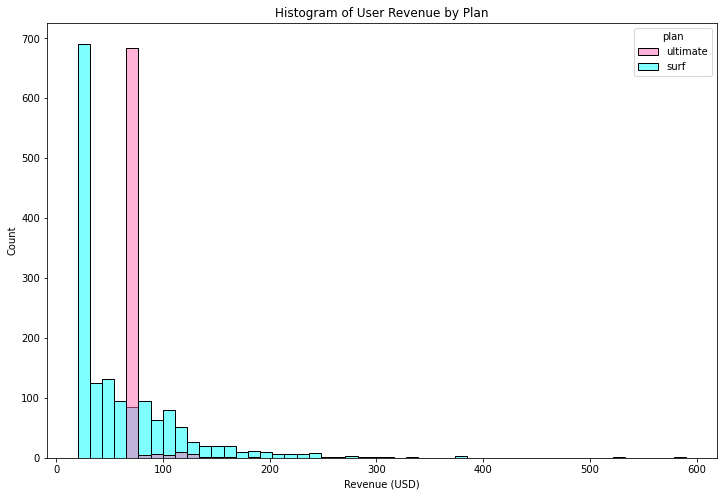

In [ ]:
# Compare the users internet usage of each plan require each month. Plot a histogram.

# Increase plot size
plt.figure(figsize=(12,8))

# Create histogram from seaborn
sns.histplot(data = df, x = 'revenue', hue = 'plan', \
            palette = ['hotpink','aqua'], bins = 50) \
            .set(xlabel='Revenue (USD)', ylabel='Count', \
                 title="Histogram of User Revenue by Plan")

plt.show()

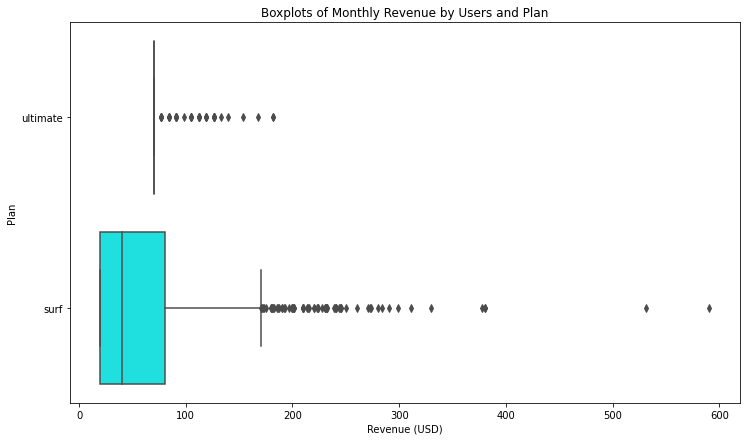

In [ ]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Increase plot size
plt.figure(figsize=(12,7))

# Create boxplots of duration by 
sns.boxplot(data = df, x='revenue', y='plan', palette = ['hotpink','aqua'])\
                    .set(xlabel='Revenue (USD)', ylabel='Plan', \
                     title='Boxplots of Monthly Revenue by Users and Plan')

plt.show()

In [ ]:
# Calculate the mean, variance and standard deviation of monthly messages

# Print surf duration mean
print('surf revenue mean = ', surf['revenue'].mean().round(2))

# Print ultimate duration mean
print('ultimate revenue mean = ', ultimate['revenue'].mean().round(2))

print('')

# Print surf duration variance
print('surf revenue variance = ', surf['revenue'].var().round(2))

# Print ultimate duration variance
print('ultimate revenue variance = ', ultimate['revenue'].var().round(2))

print('')

# Print surf duration variance
print('surf revenue standard deviation = ', surf['revenue'].std().round(2))

# Print ultimate duration variance
print('ultimate revenue standard deviation = ', ultimate['revenue'].std().round(2))

surf revenue mean =  60.71
ultimate revenue mean =  72.31

surf revenue variance =  3067.84
ultimate revenue variance =  129.85

surf revenue standard deviation =  55.39
ultimate revenue standard deviation =  11.4


**Analysis**: Average revenue from ultimate users has consistently outpaced that of surf users on a month to month basis. However, the gap has shrunk. In January, a mean difference of 50 dollars seperated the two plans, a number that has since significantly tightened to only a couple dollars in December. This has occured due to rises in mean revenue by surf users as ultimate revenue means have hovered around the 70 dollar mark.

Revenue distribution shows how a significant proportion of ultimate users rarely exceed their plan limits, whilst surf users frequently go over. A strong right tail shows that around 100 surf users pay the standard ultimate rate, but many also exceed this price. Atleast a couple dozen surf users spend well over 200 dollars, whereas no ultimate users spend the same amount.

Having said that, ultimate users still gain a higher revenue per user and month with a mean value of 72.31 dollars. This compares to 60.71 dollars paid by surf users under the same metric. However, the variance shows that surf users are capable of paying much more or less. The difference in standard deviation between the two is 44 dollars. This means 68 percent of surf users are paying approximately between 20 dollars (minimum) and 116 dollars. 

**Conclusion**: On a revenue basis the ultimate plan provides more, but if trends continue this will change as surf users continue to exceed their plan limits.

# Statistical Hypotheses

### Hypothesis Test 1 - Average Revenue Mean Between Different Plan Users

**Population**: User revenue data across all years

**Sample:** User revenue of 500 random samples from 2018 

**Null Hypothesis**: The average revenue from users of ultimate and surf calling plans are equal.

**Alternative Hypothesis**: The average revenue from users of ultimate and surf calling plans are not equal.

**Statistical Test**: Two-sided hypothesis test on the equality of two population means. Use ttest_ind from stats using surf and ultimate revenue as the two data samples. Variances are not similar, identify in equal_var.

**Alpha**: Reject null hypothesis if p-value < **0.05**.


In [ ]:
# Save alpha value
alpha = 0.05

# Use ttest_ind to compare two dataset samples, set equal_var to false
results = stats.ttest_ind(surf['revenue'], ultimate['revenue'], equal_var = False )

# Print p-value
print('p-value:', results.pvalue)

# Print condition depending on pvalue compared to alpha
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 3.17039054811355e-15
We reject the null hypothesis


**Conclusion**: The null hypothesis that the mean revenue from users of ultimate and surf calling plans are equal is rejected.

### Hypothesis Test 2 - Average Revenue Between NY-NJ and Other Areas

**Population**: User revenue data across all years in NY-NJ and other areas

**Sample:** User revenue of 500 random samples from 2018 in NY-NJ and other areas

**Null Hypothesis**: The average revenue from users in NY-NJ and other areas are equal.

**Alternative Hypothesis**: The average revenue from users in NY-NJ and other areas are not equal.

**Statistical Test**: Two-sided hypothesis test on the equality of two population means.

**Alpha**: Reject null hypothesis if p-value < **0.05**.

In [ ]:
# Merge location data from users to df, save as loc
loc = df.merge(users[['user_id','city']], on='user_id')

# Create ny_nj and other dataframes
ny_nj = loc[loc['city'] == 'New York-Newark-Jersey City, NY-NJ-PA']

other = loc[loc['city'] != 'New York-Newark-Jersey City, NY-NJ-PA']

In [ ]:
# Test the hypotheses

# Use ttest_ind to compare two dataset samples, set equal_var to false
results = stats.ttest_ind(ny_nj['revenue'], other['revenue'])

# Print p-value
print('p-value:', results.pvalue)

# Print condition depending on pvalue compared to alpha
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.04355743162134274
We reject the null hypothesis


**Conclusion**: The null hypothesis that the average revenue from users in NY-NJ and other areas are equal is rejected.

## General conclusion

### Revenue

The ultimate plan is the best for revenue. However, the surf plan is on the way to becoming the more profitable plan. This is due to surf plan user behaviour that shows that excess charges for calls, messages, and internet usage are all on the rise. Meanwhile, ultimate plan behavior is stagnant. In December, the difference in revenue between the two plans is almost negligible.


### Hypothesis Tests

- The mean revenue between ultimate and surf plan users is not the same. 
- The mean revenue between users in the NY-NJ area are not the same as those in other areas.

### Assumptions:

- User behavior will continue to behave as it has.
- The sample data provided is a fair representation of the true population.